# Comparing performance
This is a supplemental notebook for comparing the performance of the quantized model at different bit-widths to that of the original model.

The results should align with the observations made in literature. See [here](https://github.com/zhangks98/eeg-adapt) for the benchmark.

**Note:** This notebook should be run using CUDA as training can take time.

In [ ]:
import os
import json
import h5py
import torch
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F


from os.path import join as pjoin
from models.quantized_deep4 import QuantDeep4Net
from braindecode.models.deep4 import Deep4Net
from braindecode.torch_ext.optimizers import AdamW
from braindecode.torch_ext.util import set_random_seeds

## Setup

In [ ]:
n_classes = 2
subjs = range(1, 55)
datapath = "./dataset/KU_mi_smt.h5"
outpath = "./results/"
dfile = h5py.File(datapath, 'r')
torch.cuda.set_device(0)
set_random_seeds(seed=20200205, cuda=True)

In [5]:
def get_data(subj):
    dpath = '/s' + str(subj)
    X = dfile[pjoin(dpath, 'X')][:]
    Y = dfile[pjoin(dpath, 'Y')][:]
    return X, Y

## Train Original Deep4 Model

In [6]:
%%time
for subj in subjs:
    # Get data for within-subject classification
    print("Running subject: ", subj)
    X, Y = get_data(subj)
    X_train, Y_train = X[:200], Y[:200]
    X_val, Y_val = X[200:300], Y[200:300]
    X_test, Y_test = X[300:], Y[300:]

    suffix = 's' + str(subj)
    n_classes = 2
    in_chans = X.shape[1]

    # final_conv_length = auto ensures we only get a single output in the time dimension
    model = Deep4Net(in_chans=in_chans, n_classes=n_classes,
                     input_time_length=X.shape[2],
                     final_conv_length='auto').cuda()

    # these are good values for the deep model
    optimizer = AdamW(model.parameters(), lr=1 * 0.01, weight_decay=0.5*0.001)
    model.compile(loss=F.nll_loss, optimizer=optimizer, iterator_seed=1, )
    
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        model.fit(X_train, Y_train, epochs=200, batch_size=16, scheduler='cosine',
                  validation_data=(X_val, Y_val), remember_best_column='valid_loss')
    
        test_loss = model.evaluate(X_test, Y_test)
        
    model.epochs_df.to_csv(pjoin(outpath, 'float32/epochs_' + suffix + '.csv'))
    with open(pjoin(outpath, 'float32/test_subj_' + str(subj) + '.json'), 'w') as f:
        json.dump(test_loss, f)


Running subject:  1
Running subject:  2
Running subject:  3
Running subject:  4
Running subject:  5
Running subject:  6
Running subject:  7
Running subject:  8
Running subject:  9
Running subject:  10
Running subject:  11
Running subject:  12
Running subject:  13
Running subject:  14
Running subject:  15
Running subject:  16
Running subject:  17
Running subject:  18
Running subject:  19
Running subject:  20
Running subject:  21
Running subject:  22
Running subject:  23
Running subject:  24
Running subject:  25
Running subject:  26
Running subject:  27
Running subject:  28
Running subject:  29
Running subject:  30
Running subject:  31
Running subject:  32
Running subject:  33
Running subject:  34
Running subject:  35
Running subject:  36
Running subject:  37
Running subject:  38
Running subject:  39
Running subject:  40
Running subject:  41
Running subject:  42
Running subject:  43
Running subject:  44
Running subject:  45
Running subject:  46
Running subject:  47
Running subject:  48
R

## Train Quantized Models (int8 -> int2)

In [7]:
%%time
for subj in subjs:
    # Get data for within-subject classification
    print("Running subject: ", subj)
    X, Y = get_data(subj)
    X_train, Y_train = X[:200], Y[:200]
    X_val, Y_val = X[200:300], Y[200:300]
    X_test, Y_test = X[300:], Y[300:]

    suffix = 's' + str(subj)
    n_classes = 2
    in_chans = X.shape[1]

    # final_conv_length = auto ensures we only get a single output in the time dimension
    QuantDeep4Net(in_chans=in_chans, n_classes=n_classes,
                 input_time_length=X.shape[2],
                 final_conv_length=1, split_first_layer=False, act_bit_width=8, weight_bit_width=8).cuda()

    # these are good values for the deep model
    optimizer = AdamW(model.parameters(), lr=1 * 0.01, weight_decay=0.5*0.001)
    model.compile(loss=F.nll_loss, optimizer=optimizer, iterator_seed=1, )
    
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        model.fit(X_train, Y_train, epochs=200, batch_size=16, scheduler='cosine',
                  validation_data=(X_val, Y_val), remember_best_column='valid_loss')
    
        test_loss = model.evaluate(X_test, Y_test)
        
    model.epochs_df.to_csv(pjoin(outpath, 'int8/epochs_' + suffix + '.csv'))
    with open(pjoin(outpath, 'int8/test_subj_' + str(subj) + '.json'), 'w') as f:
        json.dump(test_loss, f)


Running subject:  1
Running subject:  2
Running subject:  3
Running subject:  4
Running subject:  5
Running subject:  6
Running subject:  7
Running subject:  8
Running subject:  9
Running subject:  10
Running subject:  11
Running subject:  12
Running subject:  13
Running subject:  14
Running subject:  15
Running subject:  16
Running subject:  17
Running subject:  18
Running subject:  19
Running subject:  20
Running subject:  21
Running subject:  22
Running subject:  23
Running subject:  24
Running subject:  25
Running subject:  26
Running subject:  27
Running subject:  28
Running subject:  29
Running subject:  30
Running subject:  31
Running subject:  32
Running subject:  33
Running subject:  34
Running subject:  35
Running subject:  36
Running subject:  37
Running subject:  38
Running subject:  39
Running subject:  40
Running subject:  41
Running subject:  42
Running subject:  43
Running subject:  44
Running subject:  45
Running subject:  46
Running subject:  47
Running subject:  48
R

In [8]:
%%time
for subj in subjs:
    # Get data for within-subject classification
    print("Running subject: ", subj)
    X, Y = get_data(subj)
    X_train, Y_train = X[:200], Y[:200]
    X_val, Y_val = X[200:300], Y[200:300]
    X_test, Y_test = X[300:], Y[300:]

    suffix = 's' + str(subj)
    n_classes = 2
    in_chans = X.shape[1]

    # final_conv_length = auto ensures we only get a single output in the time dimension
    QuantDeep4Net(in_chans=in_chans, n_classes=n_classes,
                 input_time_length=X.shape[2],
                 final_conv_length=1, split_first_layer=False, act_bit_width=6, weight_bit_width=6).cuda()

    # these are good values for the deep model
    optimizer = AdamW(model.parameters(), lr=1 * 0.01, weight_decay=0.5*0.001)
    model.compile(loss=F.nll_loss, optimizer=optimizer, iterator_seed=1, )
    
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        model.fit(X_train, Y_train, epochs=200, batch_size=16, scheduler='cosine',
                  validation_data=(X_val, Y_val), remember_best_column='valid_loss')
    
        test_loss = model.evaluate(X_test, Y_test)
        
    model.epochs_df.to_csv(pjoin(outpath, 'int6/epochs_' + suffix + '.csv'))
    with open(pjoin(outpath, 'int6/test_subj_' + str(subj) + '.json'), 'w') as f:
        json.dump(test_loss, f)


Running subject:  1
Running subject:  2
Running subject:  3
Running subject:  4
Running subject:  5
Running subject:  6
Running subject:  7
Running subject:  8
Running subject:  9
Running subject:  10
Running subject:  11
Running subject:  12
Running subject:  13
Running subject:  14
Running subject:  15
Running subject:  16
Running subject:  17
Running subject:  18
Running subject:  19
Running subject:  20
Running subject:  21
Running subject:  22
Running subject:  23
Running subject:  24
Running subject:  25
Running subject:  26
Running subject:  27
Running subject:  28
Running subject:  29
Running subject:  30
Running subject:  31
Running subject:  32
Running subject:  33
Running subject:  34
Running subject:  35
Running subject:  36
Running subject:  37
Running subject:  38
Running subject:  39
Running subject:  40
Running subject:  41
Running subject:  42
Running subject:  43
Running subject:  44
Running subject:  45
Running subject:  46
Running subject:  47
Running subject:  48
R

In [10]:
%%time
for subj in subjs:
    # Get data for within-subject classification
    print("Running subject: ", subj)
    X, Y = get_data(subj)
    X_train, Y_train = X[:200], Y[:200]
    X_val, Y_val = X[200:300], Y[200:300]
    X_test, Y_test = X[300:], Y[300:]

    suffix = 's' + str(subj)
    n_classes = 2
    in_chans = X.shape[1]

    # final_conv_length = auto ensures we only get a single output in the time dimension
    QuantDeep4Net(in_chans=in_chans, n_classes=n_classes,
                 input_time_length=X.shape[2],
                 final_conv_length=1, split_first_layer=False, act_bit_width=4, weight_bit_width=4).cuda()

    # these are good values for the deep model
    optimizer = AdamW(model.parameters(), lr=1 * 0.01, weight_decay=0.5*0.001)
    model.compile(loss=F.nll_loss, optimizer=optimizer, iterator_seed=1, )
    
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        model.fit(X_train, Y_train, epochs=200, batch_size=16, scheduler='cosine',
                  validation_data=(X_val, Y_val), remember_best_column='valid_loss')
    
        test_loss = model.evaluate(X_test, Y_test)
        
    model.epochs_df.to_csv(pjoin(outpath, 'int4/epochs_' + suffix + '.csv'))
    with open(pjoin(outpath, 'int4/test_subj_' + str(subj) + '.json'), 'w') as f:
        json.dump(test_loss, f)


Running subject:  1
Running subject:  2
Running subject:  3
Running subject:  4
Running subject:  5
Running subject:  6
Running subject:  7
Running subject:  8
Running subject:  9
Running subject:  10
Running subject:  11
Running subject:  12
Running subject:  13
Running subject:  14
Running subject:  15
Running subject:  16
Running subject:  17
Running subject:  18
Running subject:  19
Running subject:  20
Running subject:  21
Running subject:  22
Running subject:  23
Running subject:  24
Running subject:  25
Running subject:  26
Running subject:  27
Running subject:  28
Running subject:  29
Running subject:  30
Running subject:  31
Running subject:  32
Running subject:  33
Running subject:  34
Running subject:  35
Running subject:  36
Running subject:  37
Running subject:  38
Running subject:  39
Running subject:  40
Running subject:  41
Running subject:  42
Running subject:  43
Running subject:  44
Running subject:  45
Running subject:  46
Running subject:  47
Running subject:  48
R

In [9]:
%%time
for subj in subjs:
    # Get data for within-subject classification
    print("Running subject: ", subj)
    X, Y = get_data(subj)
    X_train, Y_train = X[:200], Y[:200]
    X_val, Y_val = X[200:300], Y[200:300]
    X_test, Y_test = X[300:], Y[300:]

    suffix = 's' + str(subj)
    n_classes = 2
    in_chans = X.shape[1]

    # final_conv_length = auto ensures we only get a single output in the time dimension
    QuantDeep4Net(in_chans=in_chans, n_classes=n_classes,
                 input_time_length=X.shape[2],
                 final_conv_length=1, split_first_layer=False, act_bit_width=2, weight_bit_width=2).cuda()

    # these are good values for the deep model
    optimizer = AdamW(model.parameters(), lr=1 * 0.01, weight_decay=0.5*0.001)
    model.compile(loss=F.nll_loss, optimizer=optimizer, iterator_seed=1, )
    
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        model.fit(X_train, Y_train, epochs=200, batch_size=16, scheduler='cosine',
                  validation_data=(X_val, Y_val), remember_best_column='valid_loss')
    
        test_loss = model.evaluate(X_test, Y_test)
        
    model.epochs_df.to_csv(pjoin(outpath, 'int2/epochs_' + suffix + '.csv'))
    with open(pjoin(outpath, 'int2/test_subj_' + str(subj) + '.json'), 'w') as f:
        json.dump(test_loss, f)


Running subject:  1
Running subject:  2
Running subject:  3
Running subject:  4
Running subject:  5
Running subject:  6
Running subject:  7
Running subject:  8
Running subject:  9
Running subject:  10
Running subject:  11
Running subject:  12
Running subject:  13
Running subject:  14
Running subject:  15
Running subject:  16
Running subject:  17
Running subject:  18
Running subject:  19
Running subject:  20
Running subject:  21
Running subject:  22
Running subject:  23
Running subject:  24
Running subject:  25
Running subject:  26
Running subject:  27
Running subject:  28
Running subject:  29
Running subject:  30
Running subject:  31
Running subject:  32
Running subject:  33
Running subject:  34
Running subject:  35
Running subject:  36
Running subject:  37
Running subject:  38
Running subject:  39
Running subject:  40
Running subject:  41
Running subject:  42
Running subject:  43
Running subject:  44
Running subject:  45
Running subject:  46
Running subject:  47
Running subject:  48
R

In [ ]:
# Close the data file once training is done
dfile.close()

## Plot results

In [3]:
# Paths to folders
path = "./results/"
folders = ["float32", "int8", "int6", "int4", "int2"]
subjs = range(1, 55)

# Load data
results = {}
for folder in folders:
    accuracies = []
    for subj in subjs:
        file = f"test_subj_{subj}.json"
        with open(os.path.join(path + folder, file)) as f:
            data = json.load(f)
            acc = 1 - data["misclass"]  # accuracy = 1 - misclassification
            accuracies.append(acc)
    results[folder] = accuracies

In [6]:
print("Quantization Summary (Accuracy)")
print("-" * 50)
print(f"{'Type':<10}{'Mean':>10}{'Std Dev':>12}")
print("-" * 50)

for folder in folders:
    accs = np.array(results[folder])
    mean = accs.mean()
    std = accs.std()
    print(f"{folder:<10}{mean:>10.4f}{std:>12.4f}")

Quantization Summary (Accuracy)
--------------------------------------------------
Type            Mean     Std Dev
--------------------------------------------------
float32       0.6341      0.1423
int8          0.6831      0.1458
int6          0.6813      0.1393
int4          0.6856      0.1433
int2          0.6691      0.1483


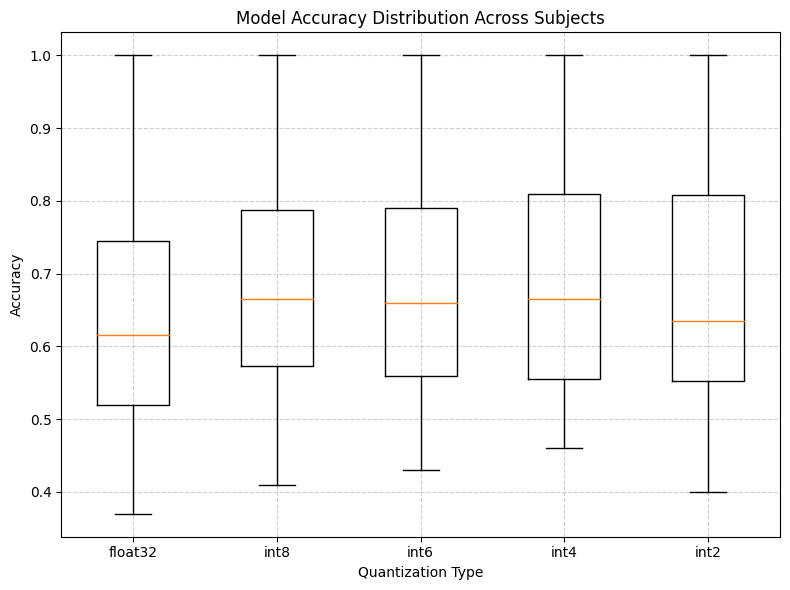

In [4]:
# --- Plot 1: Boxplot (distribution across subjects) ---
plt.figure(figsize=(8, 6))
plt.boxplot([results[f] for f in folders], labels=folders)
plt.ylabel("Accuracy")
plt.xlabel("Quantization Type")
plt.title("Model Accuracy Distribution Across Subjects")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [9]:
subject_ids = [f"subj_{subj}" for subj in subjs]

# Create DataFrame
df = pd.DataFrame({q: results[q] for q in folders}, index=subject_ids)
df.index.name = "Subject"

# Print nicely
print("\nPer-Subject Accuracy Table")
print(df.round(4))


Per-Subject Accuracy Table
         float32  int8  int6  int4  int2
Subject                                 
subj_1      0.48  0.65  0.82  0.77  0.75
subj_2      0.80  0.61  0.84  0.83  0.88
subj_3      0.69  0.75  0.81  0.81  0.82
subj_4      0.83  0.81  0.90  0.86  0.91
subj_5      0.45  0.57  0.61  0.60  0.57
subj_6      1.00  1.00  1.00  1.00  1.00
subj_7      0.78  0.77  0.79  0.81  0.83
subj_8      0.79  0.83  0.79  0.79  0.79
subj_9      0.49  0.52  0.52  0.60  0.50
subj_10     0.37  0.49  0.50  0.52  0.45
subj_11     0.52  0.49  0.65  0.55  0.62
subj_12     0.72  0.67  0.64  0.59  0.69
subj_13     0.52  0.59  0.65  0.58  0.54
subj_14     0.46  0.57  0.63  0.54  0.57
subj_15     0.76  0.87  0.85  0.84  0.85
subj_16     0.58  0.62  0.61  0.60  0.65
subj_17     0.56  0.54  0.51  0.59  0.60
subj_18     0.52  0.54  0.51  0.49  0.47
subj_19     0.42  0.60  0.63  0.63  0.62
subj_20     0.62  0.53  0.66  0.67  0.62
subj_21     0.48  0.50  0.50  0.57  0.51
subj_22     0.49  0.41  0.43 

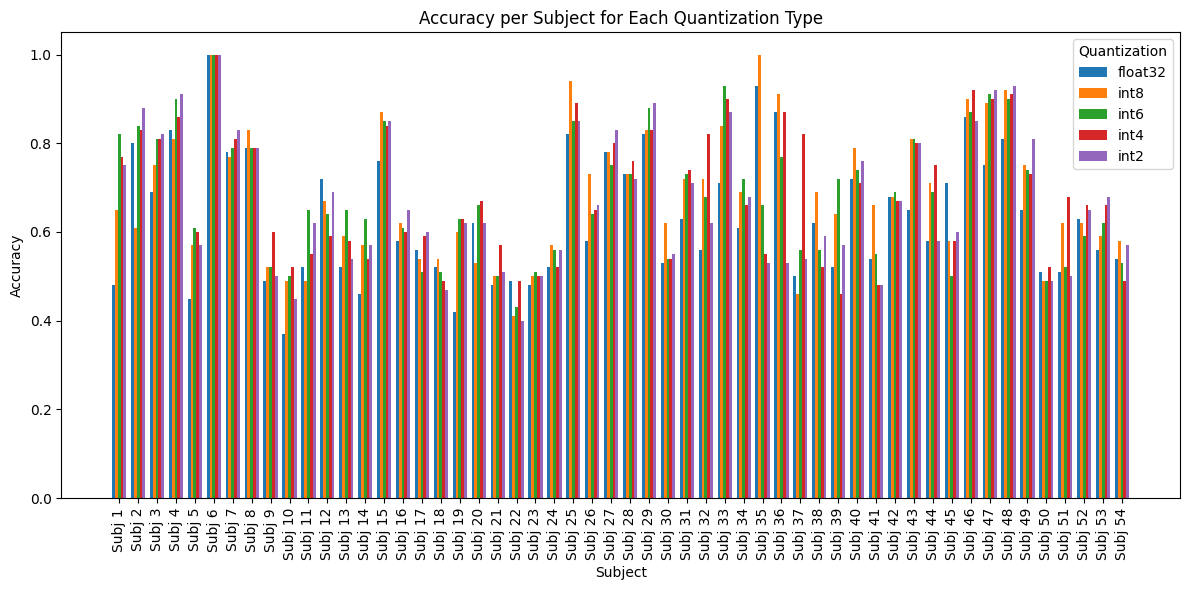

In [5]:
# --- Plot 2: Bar chart (accuracy per subject) ---
# Assume same subjects in each folder
num_subjects = len(next(iter(results.values())))
x = np.arange(num_subjects)

plt.figure(figsize=(12, 6))
bar_width = 0.15
for i, folder in enumerate(folders):
    plt.bar(x + i * bar_width, results[folder], width=bar_width, label=folder)

plt.xlabel("Subject")
plt.ylabel("Accuracy")
plt.title("Accuracy per Subject for Each Quantization Type")
plt.xticks(x + bar_width * (len(folders) - 1) / 2, [f"Subj {i+1}" for i in range(num_subjects)], rotation=90)
plt.legend(title="Quantization")
plt.tight_layout()
plt.show()